In [1]:
!nvidia-smi

Thu Nov 23 06:54:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir('/content/drive/My Drive')
!pwd

/content/drive/My Drive


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn.functional as F
from torch.utils.data import random_split
torch.cuda.empty_cache()
from sklearn.metrics import f1_score

%matplotlib inline
%load_ext autoreload
%autoreload 2

# LOADING THE TRAINING SET

In [5]:
# load the data

import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os
import matplotlib.image as mpimg

class SatelliteDataset(Dataset):
    def __init__(self, images_dir, ground_truth_dir, transform=None):
        self.images_dir = images_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, self.images[idx])
        image = mpimg.imread(img_name)

        ground_truth_name = os.path.join(self.ground_truth_dir, self.images[idx])
        ground_truth = mpimg.imread(ground_truth_name)

        if self.transform:
            image = self.transform(image)
            ground_truth = self.transform(ground_truth)

        return image, ground_truth


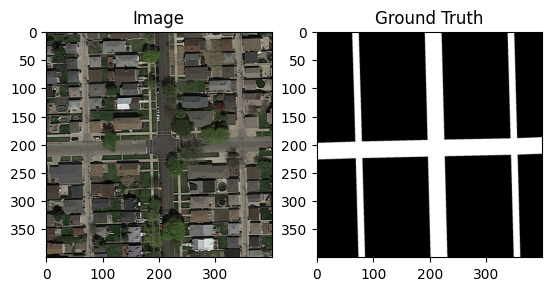

In [6]:
import matplotlib.pyplot as plt

transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = SatelliteDataset("training/images", "training/groundtruth", transform=transform)

plt.subplot(1, 2, 1)

plt.imshow(dataset[0][0].permute(1, 2, 0))
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(dataset[0][1].squeeze(), cmap='gray')

plt.title('Ground Truth')

plt.show()



# defining the model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Double Convolution block
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

# Up Convolution block
class UpConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UpConv, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        return self.up(x)

# U-Net Model with adjusted feature channels
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()

        # Down
        self.dc1 = DoubleConv(n_channels, 64)
        self.dc2 = DoubleConv(64, 128)
        self.dc3 = DoubleConv(128, 256)
        self.dc4 = DoubleConv(256, 512)
        self.dc5 = DoubleConv(512, 1024)

        # Up
        self.up1 = UpConv(1024, 512)
        self.dc6 = DoubleConv(1024, 512)
        self.up2 = UpConv(512, 256)
        self.dc7 = DoubleConv(512, 256)
        self.up3 = UpConv(256, 128)
        self.dc8 = DoubleConv(256, 128)
        self.up4 = UpConv(128, 64)
        self.dc9 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.dc1(x)
        x2 = self.dc2(F.max_pool2d(x1, 2))
        x3 = self.dc3(F.max_pool2d(x2, 2))
        x4 = self.dc4(F.max_pool2d(x3, 2))
        x5 = self.dc5(F.max_pool2d(x4, 2))

        x = self.up1(x5)
        x = torch.cat([x, x4], dim=1)
        x = self.dc6(x)

        x = self.up2(x)
        x = torch.cat([x, x3], dim=1)
        x = self.dc7(x)

        x = self.up3(x)
        x = torch.cat([x, x2], dim=1)
        x = self.dc8(x)

        x = self.up4(x)
        x = torch.cat([x, x1], dim=1)
        x = self.dc9(x)

        logits = self.outc(x)
        return logits


# defining the loss function

In [8]:
class SoftDiceLoss(nn.Module):
    def __init__(self):
        super(SoftDiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        # Flatten label and prediction tensors
        inputs = torch.sigmoid(inputs).view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_coeff = (2. * intersection + smooth) / (inputs.sum() + targets.sum() + smooth)

        return 1 - dice_coeff

bce_loss = nn.BCEWithLogitsLoss()
soft_dice_loss = SoftDiceLoss()

def calc_loss(pred, target):
    return  soft_dice_loss(pred, target) + bce_loss(pred, target) 

# Training the model

In [9]:
import time
import copy
import os
import torch
from torch.utils.data import DataLoader, random_split
from torch.optim import lr_scheduler
from tqdm import tqdm
from sklearn.metrics import f1_score

# Import your UNet model and other necessary components here
# from your_model_file import UNet, calc_loss

# Define device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Splitting dataset into train and validation sets
# Assumption: 'dataset' is predefined
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for train and validation sets
batch_size = 10  # As per your initial code
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = UNet(n_channels=3, n_classes=1).to(device)
lr = 1e-4  
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, verbose=True)

def train_model(model, optimizer, scheduler, num_epochs=10):
    best_f1 = -1e10
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        model.train()
        train_loss = 0.0
        train_samples = 0
        train_f1 = 0.0

        for inputs, labels in tqdm(train_dataloader, desc="Training"):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels)
                loss.backward()
                optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_samples += inputs.size(0)

            preds = (outputs > 0.5)
            labels_flat = labels.view(-1).cpu().numpy()
            labels_flat = (labels_flat>0.5)

            preds_flat = preds.view(-1).cpu().numpy()
            train_f1 += f1_score(labels_flat, preds_flat, average='binary')


        train_epoch_loss = train_loss / train_samples
        train_epoch_f1 = train_f1 / train_samples
        print("Training Loss: {:.4f}, Training F1 Score: {:.4f}".format(train_epoch_loss, train_epoch_f1))

        model.eval()
        val_loss = 0.0
        val_samples = 0
        val_f1 = 0.0

        for inputs, labels in tqdm(val_dataloader, desc="Validation"):
            inputs, labels = inputs.to(device), labels.to(device)

            with torch.set_grad_enabled(False):
                outputs = model(inputs)
                loss = calc_loss(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                val_samples += inputs.size(0)

                preds = (outputs > 0.5)
                labels_flat = labels.view(-1).cpu().numpy()
                preds_flat = preds.view(-1).cpu().numpy()
                val_f1 += f1_score(labels_flat, preds_flat, average='binary')

        val_epoch_loss = val_loss / val_samples
        val_epoch_f1 = val_f1 / val_samples
        print("Validation Loss: {:.4f}, Validation F1 Score: {:.4f}".format(val_epoch_loss, val_epoch_f1))
        
        scheduler.step(val_epoch_f1)

        if val_epoch_f1 > best_f1:
            best_f1 = val_epoch_f1
            best_model_wts = copy.deepcopy(model.state_dict())
            print("New best model saved with F1 Score: {:.4f}".format(best_f1))

    model.load_state_dict(best_model_wts)
    return model

# check if there is a .pth file in the current directory
if os.path.isfile('trained_model.pth'):
    model.load_state_dict(torch.load('trained_model.pth'))
    print("Model loaded from disk")
else:
    print("No model found, training the model:")
    trained_model = train_model(model, optimizer, scheduler, num_epochs=70)


Epoch 0/69
----------
Training Loss: 1.2926
Validation Loss: 1.3415
New best model saved with loss: 1.3415
Epoch complete in 7m 14s
Epoch 1/69
----------
Training Loss: 1.1442
Validation Loss: 1.1475
New best model saved with loss: 1.1475
Epoch complete in 1m 12s
Epoch 2/69
----------
Training Loss: 1.0457
Validation Loss: 1.0566
New best model saved with loss: 1.0566
Epoch complete in 1m 12s
Epoch 3/69
----------
Training Loss: 0.9861
Validation Loss: 1.1105
Epoch complete in 1m 12s
Epoch 4/69
----------
Training Loss: 0.9443
Validation Loss: 0.9610
New best model saved with loss: 0.9610
Epoch complete in 1m 12s
Epoch 5/69
----------
Training Loss: 0.8846
Validation Loss: 0.8618
New best model saved with loss: 0.8618
Epoch complete in 1m 12s
Epoch 6/69
----------
Training Loss: 0.8376
Validation Loss: 0.7842
New best model saved with loss: 0.7842
Epoch complete in 1m 12s
Epoch 7/69
----------
Training Loss: 0.8046
Validation Loss: 0.7495
New best model saved with loss: 0.7495
Epoch co

# visualize the results

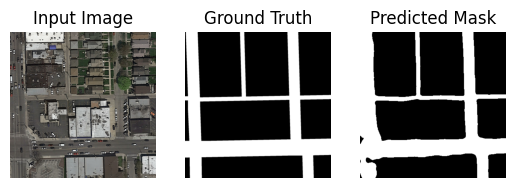

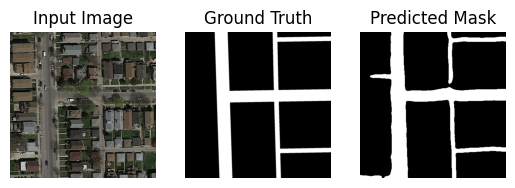

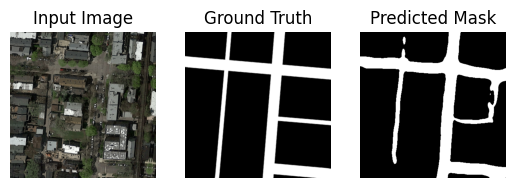

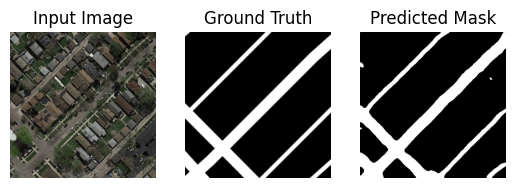

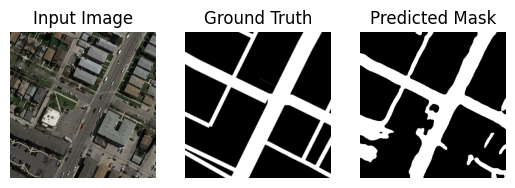

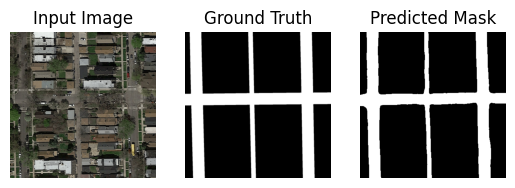

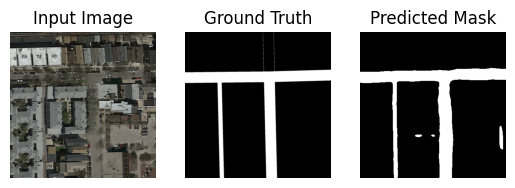

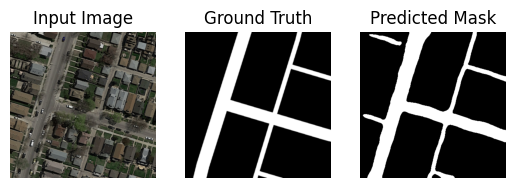

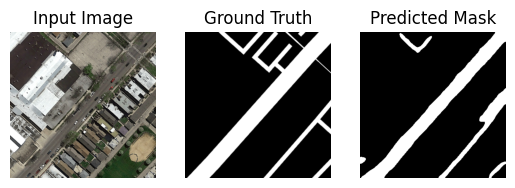

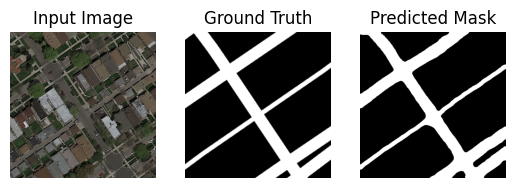

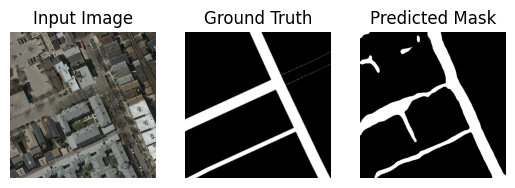

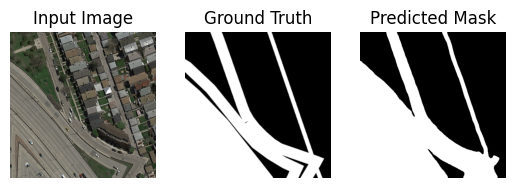

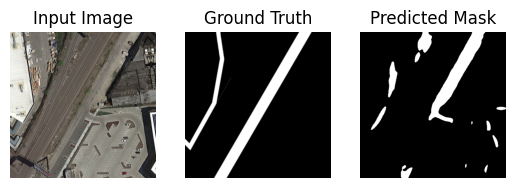

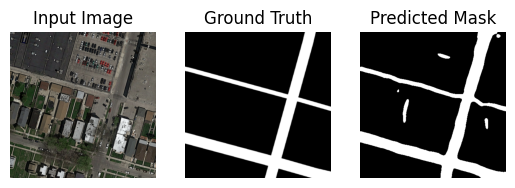

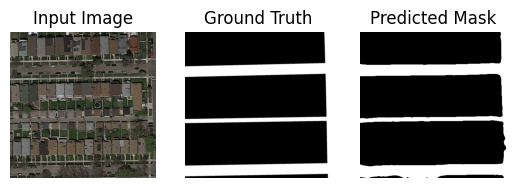

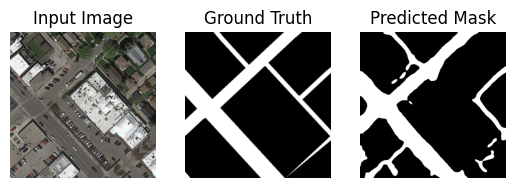

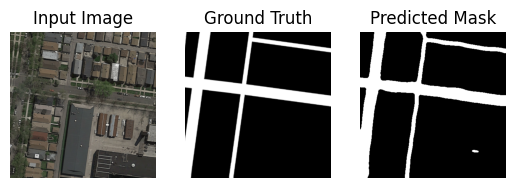

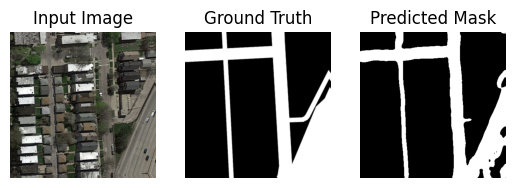

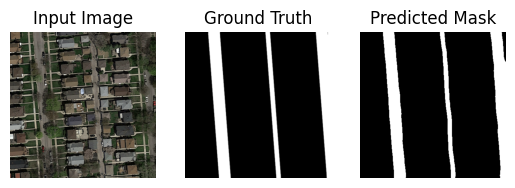

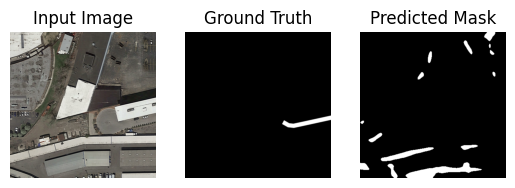

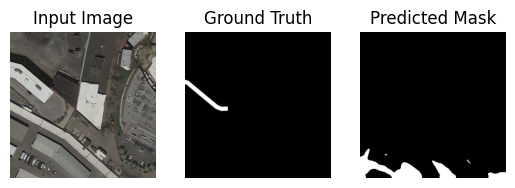

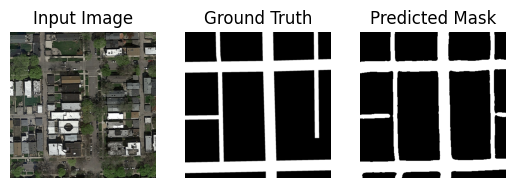

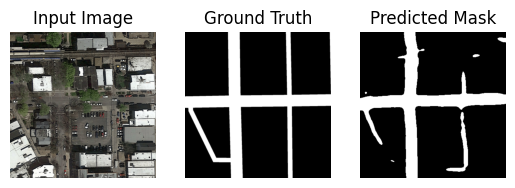

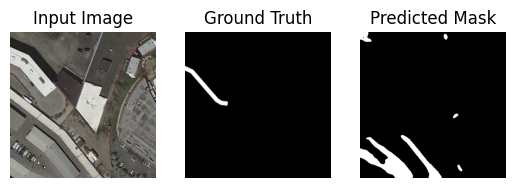

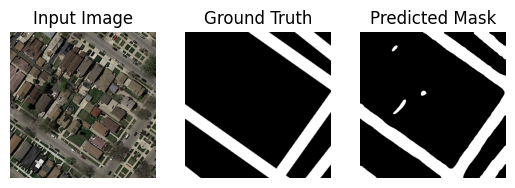

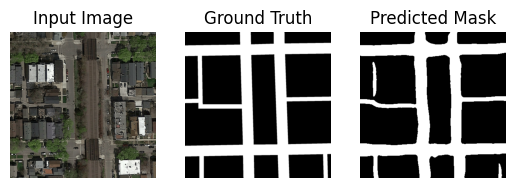

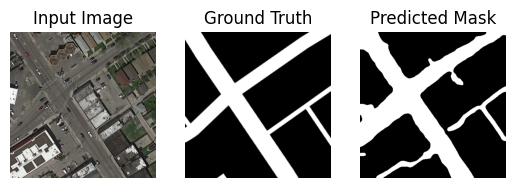

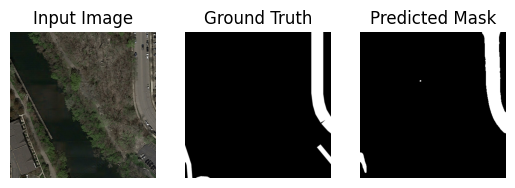

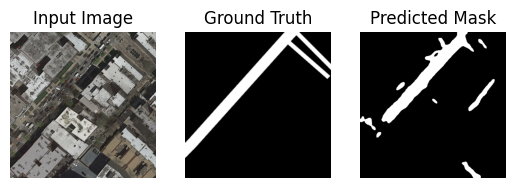

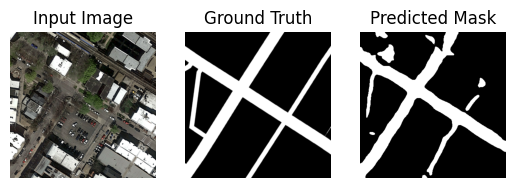

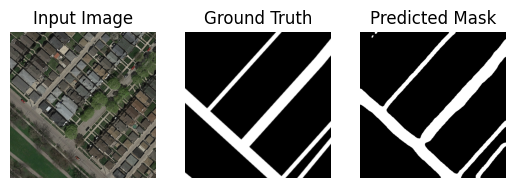

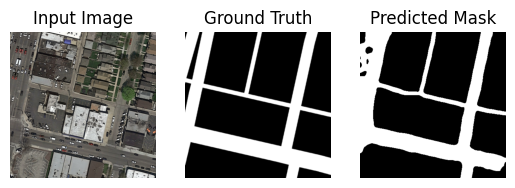

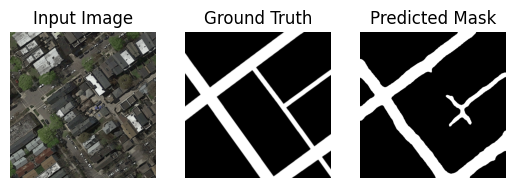

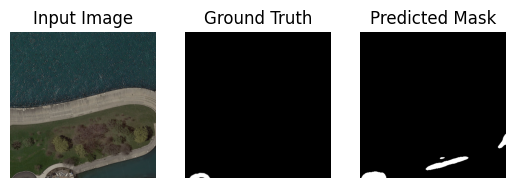

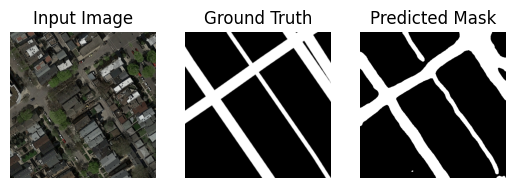

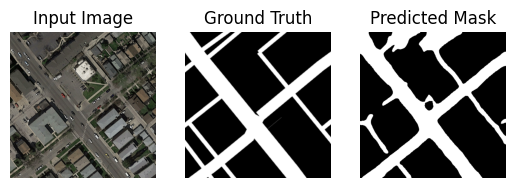

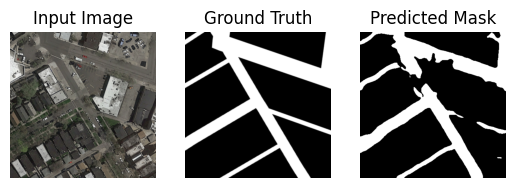

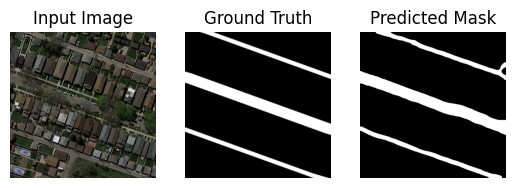

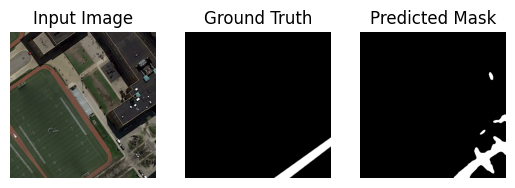

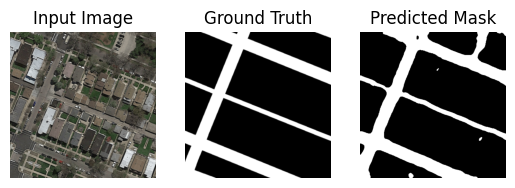

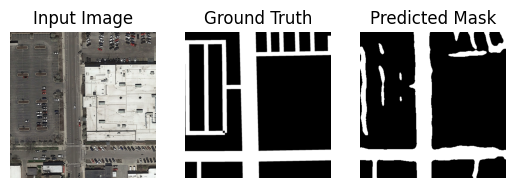

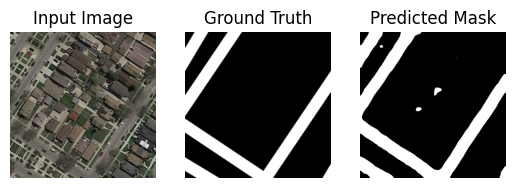

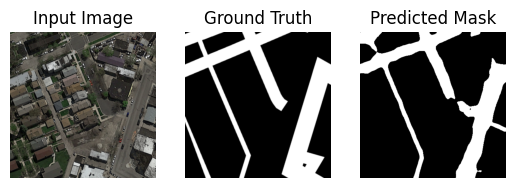

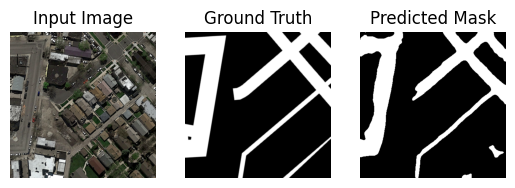

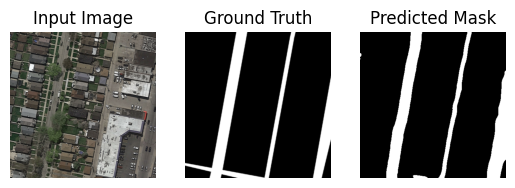

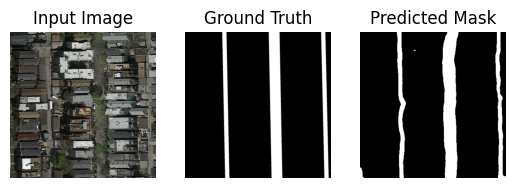

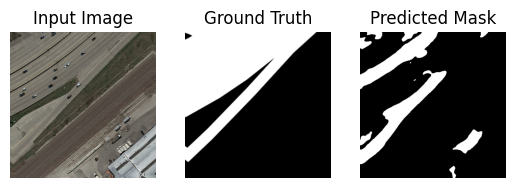

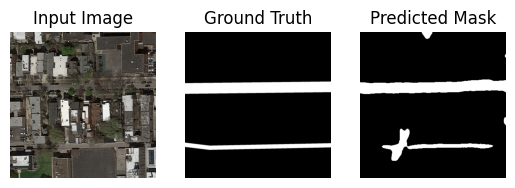

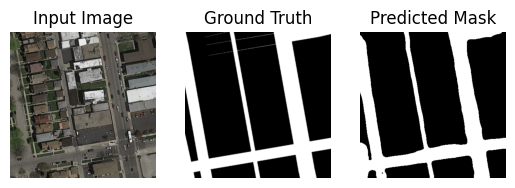

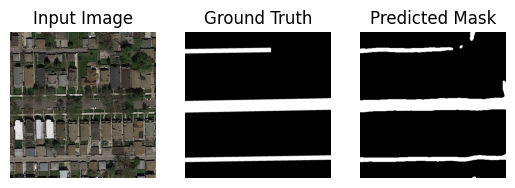

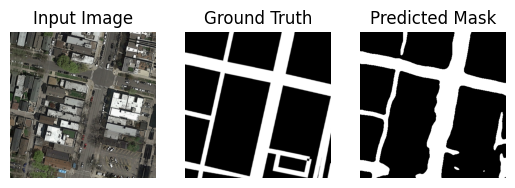

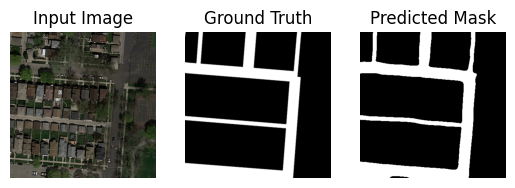

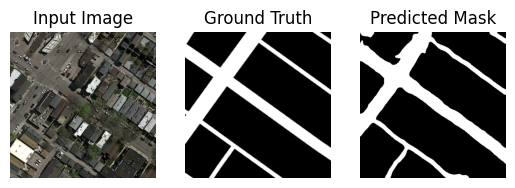

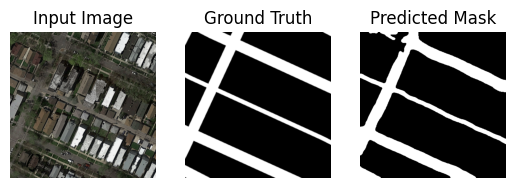

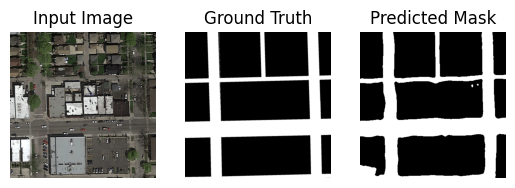

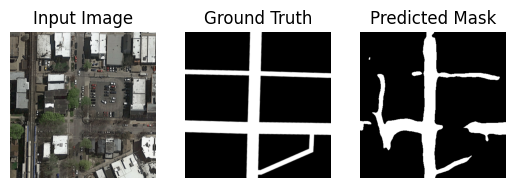

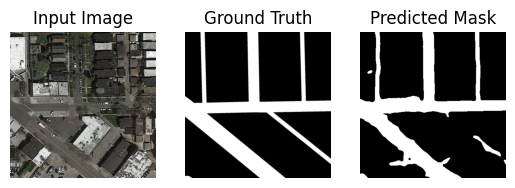

In [10]:
import matplotlib.pyplot as plt

# Set the model to evaluation mode
trained_model.eval()

# Iterate over the validation dataset
for inputs, labels in val_dataloader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass through the model
    with torch.no_grad():
        outputs = trained_model(inputs)

    # Convert the predicted output to binary values
    predicted = torch.sigmoid(outputs) > 0.5
    #predicted = outputs

    # Convert tensors to numpy arrays
    inputs = inputs.cpu().numpy()
    labels = labels.cpu().numpy()
    predicted = predicted.cpu().numpy()

    # Visualize the inputs, ground truth, and predicted masks
    for i in range(inputs.shape[0]):
        plt.subplot(1, 3, 1)
        plt.imshow(inputs[i].transpose(1, 2, 0))
        plt.title('Input Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(labels[i].squeeze(), cmap='gray')
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(predicted[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.show()


In [11]:
# Save the trained model
torch.save(trained_model.state_dict(), 'trained_model.pth')

# GENERATE THE TEST MASKS

In [12]:
class testDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_dir, f"test_{idx+1}", f"test_{idx+1}.png")
        image = mpimg.imread(img_name)

        if self.transform:
            image = self.transform(image)

        return image


In [17]:
# load the test data
transform = transforms.Compose([
    transforms.ToTensor(),  
])
# check if the test_set_masks folder exists, if not create it
if not os.path.exists("test_set_masks"):
    os.makedirs("test_set_masks")
else:
    # delete the contents of the test_set_masks folder
    for file in os.listdir("test_set_masks"):
        os.remove(os.path.join("test_set_masks", file))

# load the test dataset
test_dataset = testDataset("test_set_images", transform=transform)

# run the test data through the model and save the output masks
for i in range(len(test_dataset)):
    image = test_dataset[i].unsqueeze(0).to(device)
    with torch.no_grad():
        output = trained_model(image)
    output = output > 0.5

    output = output.squeeze().cpu().numpy()

    plt.imsave(f"test_set_masks/test_{i+1}_mask.png", output, cmap='gray')

# create the submission file 

In [ ]:
!python mask_to_submission.py